<a href="https://colab.research.google.com/github/sovandash/mel_detection_using_cnn/blob/main/melanoma_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'melanoma-skin-cancer-dataset-of-10000-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2035877%2F3376422%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240123%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240123T174653Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8394ffb549f367b2763140df0f1c60a9e9a9f6d7997596e4ad2f10d456150809e0ced912703438b7b093d76a47cf45824609174a46db0f1e8dc33c26e6827e5fb27e9b6bf68c339fe82b46b03a129db781485334479caba65cd80785a08835a5f5f3a6889443ee2f3db4d2bd3ad4ad5bd8e32fe7845628ee4035836a3a06a9a51a2e4249d9885ca5ee7ab77fcf992d20ac05f52064a7fd38592193eeb2cbcfe380cbbacfbde9aa31c3eae8859dfd287f36dfd104929b3cb893dc321cc841880064221714c030eff7d050613feee7537428ca9150ea13ef9742aa16215f32c968dad47ae505501e6fbd6b796cae61d12f911fe915f861662a48280fbd639a228c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 103508268 bytes downloaded
Downloaded and uncompressed: melanoma-skin-cancer-dataset-of-10000-images
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
train_datagen=ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 horizontal_flip=True,
                                 zoom_range=0.2,
                                 validation_split=0.2)

test_datagen=ImageDataGenerator(rescale=1/255)

In [ ]:
train_generator=train_datagen.flow_from_directory('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='binary',
                                           subset='training'
                                           )
test_generator=test_datagen.flow_from_directory('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='binary',
                                           subset='training'
                                           )
validation_generator=train_datagen.flow_from_directory('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='binary',
                                           subset='validation'
                                           )
unshuffled_test_generator=test_datagen.flow_from_directory('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='binary',
                                           shuffle=False,
                                           subset='training'
)

Found 7684 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
#plt.imshow(train_generator.next()[0][20])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPool2D,Flatten,Dense,Dropout,InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l1,l2

In [ ]:
    model=tf.keras.Sequential([

                           InputLayer(input_shape=(224,224,3)),

                           Conv2D(filters=6,kernel_size=3,padding='same',activation='relu'),
                           BatchNormalization(),

                           MaxPool2D(pool_size=4,strides=1),

                           Conv2D(filters=16,kernel_size=3,padding='valid',activation='relu'),
                           BatchNormalization(),

                           MaxPool2D(pool_size=2,strides=1),


                           #base_model,
                           Flatten(),

                           Dense(64,activation='relu'),
                           BatchNormalization(),
                           Dense(32,activation='relu'),
                           BatchNormalization(),
                           Dense(1,activation='sigmoid')

                          ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 221, 221, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 219, 219, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 219, 219, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
model.compile(optimizer=Adam(0.0001),loss='BinaryCrossentropy',metrics='accuracy')

history=model.fit(train_generator,epochs=40,verbose=1,batch_size=64,validation_data=validation_generator)

Epoch 1/40
241/241 [==============================] - 129s 498ms/step - loss: 0.3678 - accuracy: 0.8365 - val_loss: 0.5721 - val_accuracy: 0.7048
Epoch 2/40
241/241 [==============================] - 121s 501ms/step - loss: 0.2982 - accuracy: 0.8745 - val_loss: 0.3218 - val_accuracy: 0.8319
Epoch 3/40
241/241 [==============================] - 120s 497ms/step - loss: 0.2794 - accuracy: 0.8813 - val_loss: 0.2619 - val_accuracy: 0.9006
Epoch 4/40
241/241 [==============================] - 120s 498ms/step - loss: 0.2563 - accuracy: 0.8947 - val_loss: 0.2337 - val_accuracy: 0.9099
Epoch 5/40
241/241 [==============================] - 119s 495ms/step - loss: 0.2474 - accuracy: 0.8986 - val_loss: 0.2485 - val_accuracy: 0.9053
Epoch 6/40
241/241 [==============================] - 119s 495ms/step - loss: 0.2370 - accuracy: 0.9028 - val_loss: 0.2207 - val_accuracy: 0.9188
Epoch 7/40
241/241 [==============================] - 137s 570ms/step - loss: 0.2376 - accuracy: 0.9043 - val_loss: 0.2502 -

In [ ]:
model.save(r"C:\Users\sovan dash\Desktop\meloma_cnn\melanoma.keras")

In [ ]:
model.evaluate(test_generator)

32/32 [==============================] - 2s 62ms/step - loss: 0.2854 - accuracy: 0.9030


[0.28537672758102417, 0.902999997138977]

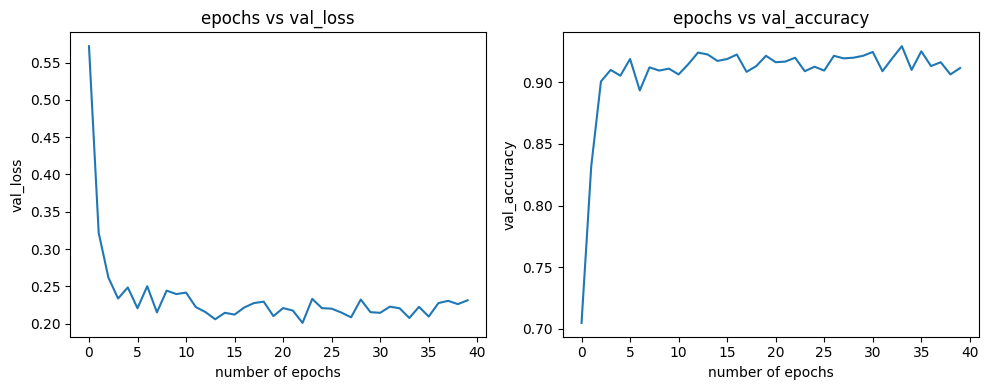

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['val_loss'])
plt.title('epochs vs val_loss')
plt.xlabel('number of epochs')
plt.ylabel('val_loss')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('epochs vs val_accuracy')
plt.xlabel('number of epochs')
plt.ylabel('val_accuracy')

plt.tight_layout()

plt.show()